In [21]:
import pandas as pd
from sklearn.decomposition import PCA

df = pd.read_csv('./nyt-frame.csv', header = 0)
data = df.iloc[:,9:]
array = data.values

pca = PCA(n_components=10)
nyt_pca = pca.fit_transform(array)

nyt_target = df.iloc[:,1].values

In [10]:
from sklearn.datasets import load_breast_cancer

bc = load_breast_cancer()
bc_data = bc.data
bc_target = bc.target

pca = PCA(n_components=10)
bc_pca = pca.fit_transform(bc_data)

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

k_values = [1, 3, 5, 7]

search = GridSearchCV(
    KNeighborsClassifier(),
    {
        'n_neighbors': k_values,
    },
    cv=10,
    scoring='accuracy'
)

search.fit(nyt_pca, nyt_target)
for k, accuracy in zip(k_values, search.cv_results_['mean_test_score']):
    print(f'k={k}, accuracy={accuracy}')

k=1, accuracy=0.9109090909090909
k=3, accuracy=0.8627272727272729
k=5, accuracy=0.8427272727272728
k=7, accuracy=0.8427272727272728


In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

k_values = [1, 3, 5, 7]

search.fit(bc_pca, bc_target)
for k, accuracy in zip(k_values, search.cv_results_['mean_test_score']):
    print(f'k={k}, accuracy={accuracy}')

k=1, accuracy=0.9156954887218045
k=3, accuracy=0.9261904761904761
k=5, accuracy=0.9297619047619046
k=7, accuracy=0.9279761904761905


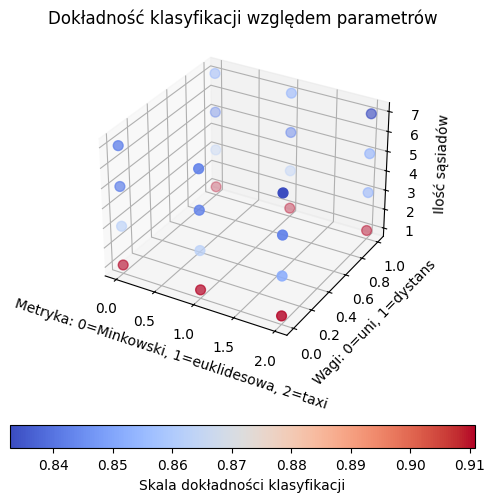

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparition(data, target):
    accuracies = []
    params = []

    k_values = [1, 3, 5, 7]

    comparation = GridSearchCV(
        KNeighborsClassifier(),
        {
            'n_neighbors': k_values,
            'weights': ['uniform', 'distance'],
            'metric': ['minkowski', 'euclidean', 'cityblock']
        },
        cv=10,
        scoring='accuracy'
    )

    comparation.fit(data, target)
    accuracies = np.array(comparation.cv_results_['mean_test_score'])
    params = np.array(list(map(lambda t: [0 if t['metric'] == 'minkowski' else 1 if t['metric'] == 'euclidean' else 2,\
                                0 if t['weights'] == 'uniform' else 1,\
                                t['n_neighbors']], comparation.cv_results_['params'])))

    fig = plt.figure(figsize=(6, 6))
    points = fig.add_subplot(111, projection='3d')

    points.scatter(params[:, 0], params[:, 1], params[:, 2], c=accuracies, cmap='coolwarm', s=50)
    points.set_xlabel('Metryka: 0=Minkowski, 1=euklidesowa, 2=taxi'),
    points.set_ylabel('Wagi: 0=uni, 1=dystans')
    points.set_zlabel('Ilość sąsiadów')
    points.set_title('Dokładność klasyfikacji względem parametrów')

    cbar = plt.colorbar(points.collections[0], ax=points, orientation='horizontal')
    cbar.set_label('Skala dokładności klasyfikacji')

    plt.show()

plot_comparition(nyt_pca, nyt_target)

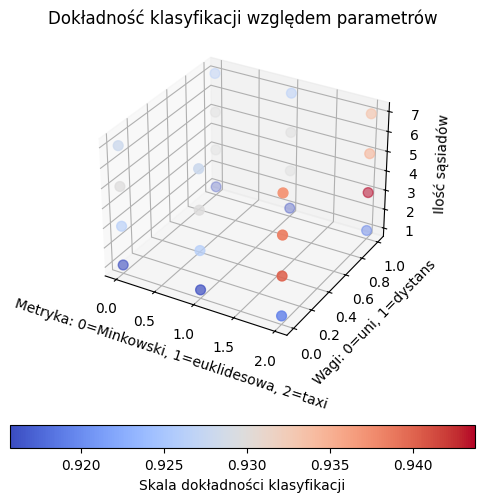

In [50]:
plot_comparition(bc_pca, bc_target)